# Classification Problem on Urban Tree Dataset

## PreProcessing

### Importing the libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, roc_curve, auc,confusion_matrix, RocCurveDisplay

### Importing the Data set, Cleaning Data and Handling Missing Values

In [31]:
df = pd.read_csv('sgl-arbres-urbains-wgs84.csv')

In [32]:
df= df.drop(["ID_ARBRE", "commune", "controle", "insecte_collet", "insecte_tronc", "insecte_houppier","circonference (en cm)", "observation_collet", "observation_tronc", "observation_houppier"], axis=1 )
#Handling Missing Values
mode_cote_voirie=df.cote_voirie.mode()[0]
mode_espece_arbre=df.espece_arbre.mode()[0]
mode_situation=df.situation.mode()[0]
mode_plaie_collet=df.plaie_collet.mode()[0]
mode_champignon_tronc=df.champignon_tronc.mode()[0]
mode_fissure_tronc=df.fissure_tronc.mode()[0]
mode_rejet_tronc=df.rejet_tronc.mode()[0]
mode_plaie_tronc=df.plaie_tronc.mode()[0]
mode_champignon_houppier=df.champignon_houppier.mode()[0]
mode_fissure_houppier=df.fissure_houppier.mode()[0]
mode_ecorce_incluse_houppier=df.ecorce_incluse_houppier.mode()[0]
mode_bois_mort_houppier=df.bois_mort_houppier.mode()[0]
mode_plaie_houppier=df.plaie_houppier.mode()[0]
mode_contrainte=df.contrainte.mode()[0]
mode_classification_diagnostic=df.classification_diagnostic.mode()[0]
median_esperance_maintien=df.esperance_maintien.median()

df=df.fillna({"cote_voirie": mode_cote_voirie, "espece_arbre": mode_espece_arbre, "situation": mode_situation,
            "plaie_collet": mode_plaie_collet, "champignon_tronc": mode_champignon_tronc,
            "fissure_tronc": mode_fissure_tronc, "rejet_tronc": mode_rejet_tronc, "plaie_tronc": mode_plaie_tronc, 
              "champignon_houppier": mode_champignon_houppier, "fissure_houppier":mode_fissure_houppier, "ecorce_incluse_houppier": mode_ecorce_incluse_houppier,
            "bois_mort_houppier": mode_bois_mort_houppier, "plaie_houppier": mode_plaie_houppier, "contrainte": mode_contrainte,
            "classification_diagnostic": mode_classification_diagnostic, "esperance_maintien": median_esperance_maintien})

In [33]:
df.head()

,quartier,site,cote_voirie,matricule_arbre,genre_arbre,espece_arbre,situation,type_sol,surf_permeable,date_plantation,...,canisse_arbre,plaie_tronc,champignon_houppier,fissure_houppier,ecorce_incluse_houppier,bois_mort_houppier,plaie_houppier,esperance_maintien,contrainte,classification_diagnostic
0,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,7,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLNC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
1,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,8,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
2,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,9,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLCF,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
3,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,1,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2
4,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,2,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2


In [34]:
#define function to swap columns so that all numerical data will be in the end columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    a, b = col_list.index(col1), col_list.index(col2)
    col_list[b], col_list[a] = col_list[a], col_list[b]
    df = df[col_list]
    return df

#swaping columns
df = swap_columns(df, 'matricule_arbre', 'contrainte')
df = swap_columns(df, 'surf_permeable', 'plaie_houppier')
df = swap_columns(df, 'date_plantation', 'bois_mort_houppier')
df = swap_columns(df, 'hauteur', 'ecorce_incluse_houppier')
df = swap_columns(df, 'diametre', 'fissure_houppier')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   quartier                   709 non-null    object 
 1   site                       709 non-null    object 
 2   cote_voirie                709 non-null    object 
 3   contrainte                 709 non-null    object 
 4   genre_arbre                709 non-null    object 
 5   espece_arbre               709 non-null    object 
 6   situation                  709 non-null    object 
 7   type_sol                   709 non-null    object 
 8   plaie_houppier             709 non-null    object 
 9   bois_mort_houppier         709 non-null    object 
 10  classe_age                 709 non-null    object 
 11  ecorce_incluse_houppier    709 non-null    object 
 12  classe_hauteur             709 non-null    object 
 13  fissure_houppier           709 non-null    object 

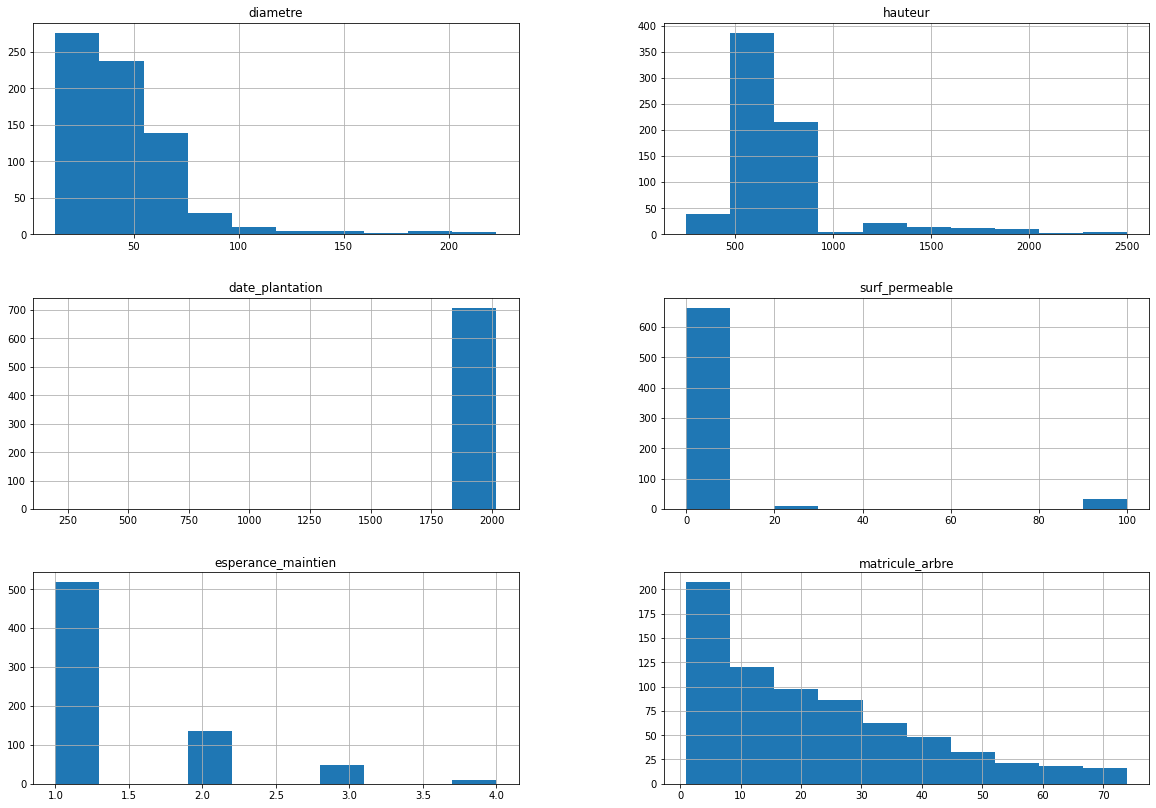

In [35]:
_ = df.hist(figsize=(20, 14))

In [36]:
cor_matrix = df.corr()
cor_matrix

,diametre,hauteur,date_plantation,surf_permeable,esperance_maintien,matricule_arbre
diametre,1.000000,0.759239,-0.155416,0.408231,0.329892,-0.109965
hauteur,0.759239,1.000000,-0.090306,0.604309,0.225723,-0.164903
date_plantation,-0.155416,-0.090306,1.000000,-0.071507,-0.033480,-0.007850
surf_permeable,0.408231,0.604309,-0.071507,1.000000,0.224826,-0.217633
esperance_maintien,0.329892,0.225723,-0.033480,0.224826,1.000000,-0.023423
matricule_arbre,-0.109965,-0.164903,-0.007850,-0.217633,-0.023423,1.000000


In [37]:
df.nunique()

quartier                      6
site                         30
cote_voirie                   2
contrainte                    2
genre_arbre                  26
espece_arbre                 37
situation                     4
type_sol                      9
plaie_houppier                5
bois_mort_houppier            3
classe_age                    4
ecorce_incluse_houppier       2
classe_hauteur                5
fissure_houppier              3
classe_circonference          7
port_arbre                    5
vigueur_pousse                4
champignon_collet             2
plaie_collet                  7
champignon_tronc              2
fissure_tronc                 3
rejet_tronc                   2
tuteurage_arbre               4
canisse_arbre                 2
plaie_tronc                   6
champignon_houppier           2
diametre                     42
hauteur                      17
date_plantation              13
surf_permeable                9
esperance_maintien            4
matricul

In [38]:
df['classification_diagnostic'].value_counts()

C2    408
C1    237
C3     43
C4     11
C5     10
Name: classification_diagnostic, dtype: int64

In [39]:
target_name = "classification_diagnostic"
target = df[target_name]
data = df.drop(columns=[target_name])

## AdaBoost

In [40]:
X = data.iloc[:].values
y = target.iloc[:].values

In [41]:
ct = ColumnTransformer(transformers=[('encoder', OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                unknown_value=-1), [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [42]:
X

array([[1.0, 5.0, 0.0, ..., 5.0, 1.0, 7],
       [1.0, 5.0, 0.0, ..., 5.0, 1.0, 8],
       [1.0, 5.0, 0.0, ..., 5.0, 1.0, 9],
       ...,
       [0.0, 11.0, 0.0, ..., 1.0, 1.0, 6],
       [0.0, 11.0, 0.0, ..., 1.0, 2.0, 7],
       [0.0, 11.0, 0.0, ..., 1.0, 1.0, 8]], dtype=object)

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [44]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 3, 1, 2, 1, 2, 3, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 3, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [45]:
print(X.shape)
print(y.shape)

(709, 32)
(709,)


In [46]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  0 237]
 [  1 408]
 [  2  43]
 [  3  11]
 [  4  10]]


In [47]:
type(X)

numpy.ndarray

In [48]:
type(y)

numpy.ndarray

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, cross_validate, validation_curve
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [94]:
%%time
results_ab=[]
for i in range (3):
    base_estimator = DecisionTreeClassifier(max_depth=i+1, criterion='entropy', random_state=0)
    classifier = AdaBoostClassifier(n_estimators=1000, base_estimator= base_estimator, algorithm= "SAMME", random_state=0)
    classifier.fit(X_train, y_train)
    #y_pred = classifier.predict(X_test)
    #accuracy_score(y_test, y_pred)
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, 
                                 cv = 7, n_jobs=8)
    results_ab.append(accuracies)
    print(accuracies)

[0.73913043 0.78021978 0.65934066 0.8021978  0.83516484 0.7032967
 0.74725275]
[0.79347826 0.78021978 0.76923077 0.8021978  0.75824176 0.72527473
 0.75824176]
[0.84782609 0.86813187 0.83516484 0.8021978  0.9010989  0.8021978
 0.8021978 ]
Wall time: 17.4 s


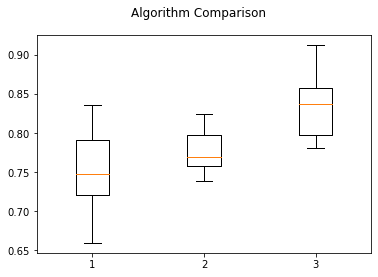

In [95]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(ab_accuracies_mean)
ax.set_xticklabels([1,2, 3])
plt.show()